In [63]:
%matplotlib inline

In [15]:
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A

In [2]:
def yolo_to_coco(img_width, img_height, yolo_bbox):
    """
    YOLO 형식의 bounding box를 COCO 형식으로 변환합니다.

    Args:
        img_width (int): 이미지 너비
        img_height (int): 이미지 높이
        yolo_bbox (list): YOLO 형식의 bounding box [x_center, y_center, width, height] (normalized)

    Returns:
        list: COCO 형식의 bounding box [x_min, y_min, width, height] (픽셀 단위)
    """
    x_center, y_center, width, height = yolo_bbox

    x_min = int((x_center - width / 2) * img_width)
    y_min = int((y_center - height / 2) * img_height)
    width = int(width * img_width)
    height = int(height * img_height)

    return [x_min, y_min, width, height]



In [6]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, yolo_bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""

    img_width = img.shape[1]
    img_height = img.shape[0]

    bbox = yolo_to_coco(img_width, img_height, yolo_bbox)
    
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


# def visualize(image, bboxes, category_ids, category_id_to_name):
#     img = image.copy()
#     for bbox, category_id in zip(bboxes, category_ids):
#         class_name = category_id_to_name[category_id]
#         img = visualize_bbox(img, bbox, class_name)
#     plt.figure(figsize=(12, 12))
#     plt.axis('off')
#     plt.imshow(img)


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        # class_name = category_id
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [7]:
image = cv2.imread('images/bus.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
# yolo에서는 2개를 txt파일에서 읽어와서 만들어준다.

In [14]:
# bboxes = [
#     [0.353086, 0.583796, 0.150617, 0.421296],
#     [0.156173, 0.600000, 0.228395, 0.474074],
#     [0.912963, 0.582407, 0.174074, 0.453704],
#     [0.047531, 0.654167, 0.092593, 0.310185],
#     [0.501852, 0.449074, 0.971605, 0.474074],
# ]

# # class_labels = ['person', 'bus']
# class_labels = [1, 1, 1, 1, 15]
category_id_to_name = {1: 'person', 15: 'bus'}

In [8]:
class_labels = []
bboxes = []

f = open('labels/bus.txt', 'r')
while True:
    line = f.readline()
    if not line: break
    cls, xc, yc, w, h = line0 = line.split(' ')

    class_labels.append(int(cls))
    bboxes.append([float(xc), float(yc), float(w), float(h)])
    
    print(line)
f.close()

1 0.353086 0.583796 0.150617 0.421296

1 0.156173 0.600000 0.228395 0.474074

1 0.912963 0.582407 0.174074 0.453704

1 0.047531 0.654167 0.092593 0.310185

15 0.501852 0.449074 0.971605 0.474074



In [9]:
bboxes

[[0.353086, 0.583796, 0.150617, 0.421296],
 [0.156173, 0.6, 0.228395, 0.474074],
 [0.912963, 0.582407, 0.174074, 0.453704],
 [0.047531, 0.654167, 0.092593, 0.310185],
 [0.501852, 0.449074, 0.971605, 0.474074]]

In [10]:
class_labels

[1, 1, 1, 1, 15]

In [11]:
image.shape

(1080, 810, 3)

In [99]:
# HorizontalFlip

transform = A.Compose([
    # A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=1),
    # A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(var_limit=(10000.0, 10000.0),p=1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))



# augmented_image = transform(image=image)['image']

In [39]:
transform = A.Compose(
    [A.Rotate(limit=(30,30),p=1)],
    bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

In [59]:
transform = A.Compose(
    [A.Rotate(limit=(30, 30),p=1,rotate_method='ellipse')],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_area=1024, min_visibility=0.1)
)

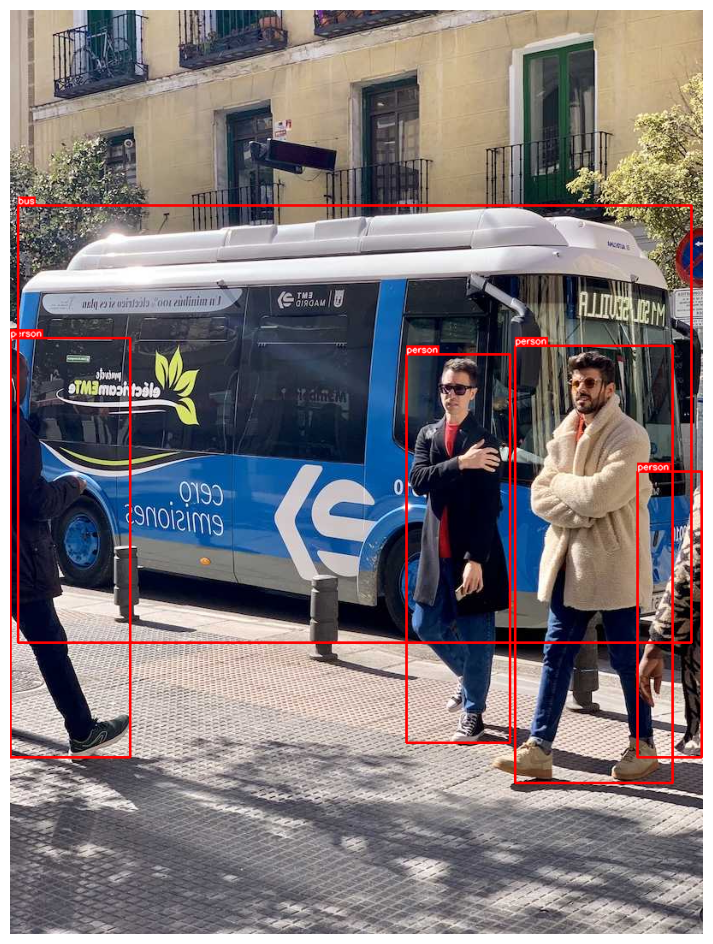

In [89]:
transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['class_labels']
visualize(transformed_image, transformed_bboxes, transformed_class_labels, category_id_to_name)

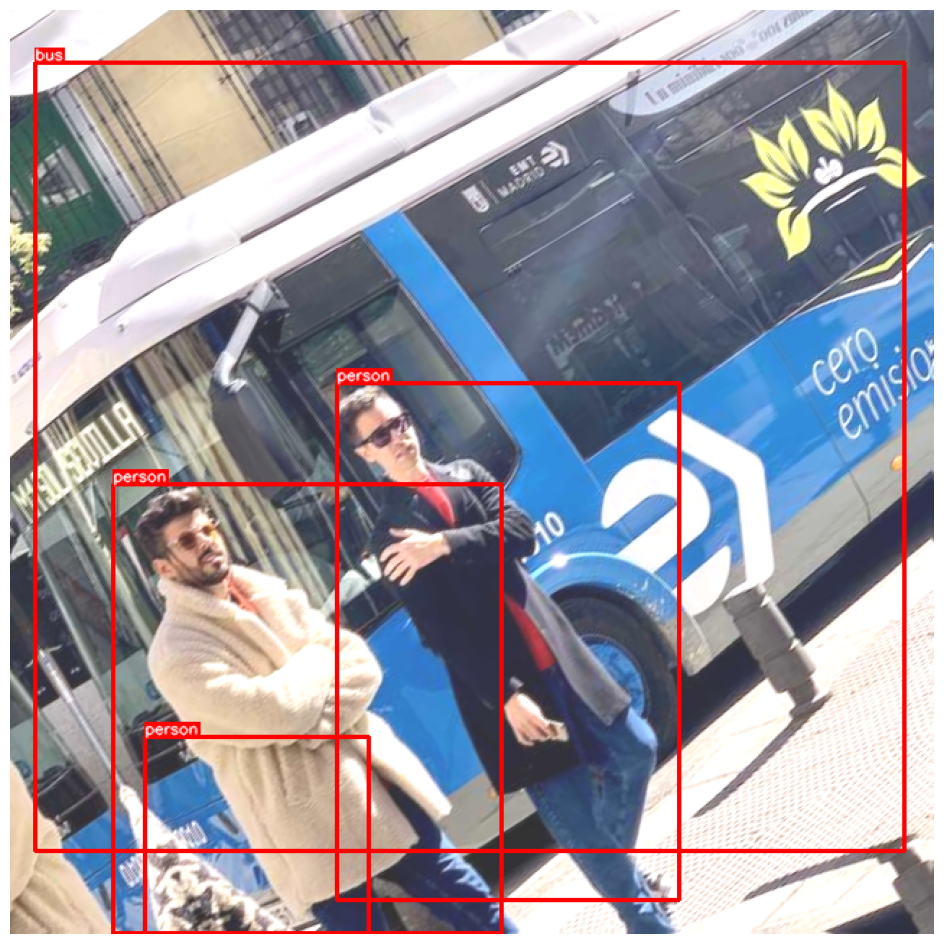

In [144]:
transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['class_labels']
visualize(transformed_image, transformed_bboxes, transformed_class_labels, category_id_to_name)

In [141]:
print(transformed_bboxes, transformed_class_labels, category_id_to_name)

[[0.3687494695186615, 0.6148433089256287, 0.1906246393918991, 0.7109370231628418], [0.13203133642673492, 0.6210938096046448, 0.26406267285346985, 0.7578123807907104], [0.983593761920929, 0.6124992966651917, 0.03281247615814209, 0.7656254768371582], [0.02031271532177925, 0.7335942983627319, 0.0406254306435585, 0.5234371423721313], [0.5, 0.3937498927116394, 1.0, 0.7874997854232788]] [1, 1, 1, 1, 15] {1: 'person', 15: 'bus'}


In [67]:
for idx, box in enumerate(transformed_bboxes):
    xc, yc, w, h = box
    print(transformed_class_labels[idx], xc, yc, w, h)
    

1 0.4286327660083771 0.6276622414588928 0.30967479944229126 0.36919674277305603
1 0.26890379190444946 0.7155376672744751 0.37284085154533386 0.4193956255912781
1 0.8718013763427734 0.41650545597076416 0.25639718770980835 0.3982934057712555
1 0.21092835068702698 0.8031884431838989 0.2217918038368225 0.27085739374160767
15 0.4676530957221985 0.4552023112773895 0.8988088369369507 0.5489045977592468


In [70]:
import os
os.getcwd()

'/Users/wonkyoung/yolov11/albumentation'

In [85]:
# 파일 생성

txtFile = 'labels/test.txt'

for idx, box in enumerate(transformed_bboxes):
    xc, yc, w, h = box
    labeltext = f"{transformed_class_labels[idx]} {xc} {yc} {w} {h}"
    print(labeltext)
    f = open(txtFile, 'a')
    f.write(labeltext)
    f.write('\n')
    f.close()
    

1 0.4286327660083771 0.6276622414588928 0.30967479944229126 0.36919674277305603
1 0.26890379190444946 0.7155376672744751 0.37284085154533386 0.4193956255912781
1 0.8718013763427734 0.41650545597076416 0.25639718770980835 0.3982934057712555
1 0.21092835068702698 0.8031884431838989 0.2217918038368225 0.27085739374160767
15 0.4676530957221985 0.4552023112773895 0.8988088369369507 0.5489045977592468


In [ ]:
# OneOf : 안에 있는 것 중에 하나를 

transform = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.GaussNoise(),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])
random.seed(42)
augmented_image = transform(image=image)['image']
visualize(augmented_image)

In [131]:
# 최종_1차

random.seed(None)

transform = A.Compose([
    A.RandomCrop(width=640, height=640, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=(-90, 90),p=0.8,rotate_method='ellipse'),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(var_limit=(10000.0, 10000.0),p=0.3),
    A.OneOf([
            A.MotionBlur(blur_limit=9, p=1),
            A.MedianBlur(blur_limit=9, p=1),
            A.Blur(blur_limit=9, p=1),
        ], p=0.7),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
